In [1]:
import pandas as pd
import numpy as np
#import scikitplot as skplt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, learning_curve

from sklearn import linear_model
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence

from sklearn.metrics import roc_auc_score, roc_curve, log_loss, brier_score_loss, confusion_matrix
from sklearn.calibration import calibration_curve

import xgboost as xgb

In [2]:
import matplotlib.pyplot as plt
#import matplotlib as mpl
import seaborn as sns #for pair-plot

In [3]:
plt.style.use('seaborn')
params = {'axes.titlesize': 'large',
        'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params)

In [4]:
def logreg_ll(variables, target, basetable):
    X = basetable[variables]
    y = basetable[target].values.ravel()
    logreg = linear_model.LogisticRegression(solver='lbfgs', max_iter = 300)
    logreg.fit(X, y)
    predictions = logreg.predict_proba(X)[:,1]
    ll = log_loss(y, predictions)
    return(ll)

def next_best(current_variables, candidate_variables, target, basetable):
    best_auc = -1
    best_ll = 100000
    best_variable = None
    for v in candidate_variables:
        #auc_v = logreg_auc(current_variables + [v], target, basetable)
        ll_v = logreg_ll(current_variables + [v], target, basetable)
        #if auc_v >= best_auc:
        #    best_auc = auc_v
        if ll_v <= best_ll:
            best_ll = ll_v
            best_variable = v
    print(best_ll)
    return (best_variable, best_ll)

In [5]:
def plot_pig_table(basetable, target, variable):
  
    # Create groups for each variable
    groups = basetable[[target,variable]].groupby(variable)
    
    #groups.groupby(target).apply(my_agg)
    pig_table = groups[target].agg({'Incidence' : np.mean, 'Observations' : np.size}).reset_index()
    
    # Plot formatting
    plt.xlabel(variable, fontsize=12)
    plt.ylabel("Observations", rotation = 0,rotation_mode="anchor", ha = "right" )
    
    # Plot the bars with sizes 
    pig_table["Observations"].plot(kind="bar", width = 0.5, color = "lightgray", edgecolor = "none") 
    
    # Plot the incidence line on secondary axis
    pig_table["Incidence"].plot(secondary_y = True)
    
    # Plot formatting
    plt.xticks(np.arange(len(pig_table)), pig_table[variable])
    plt.xlim([-0.5, len(pig_table)-0.5])
    plt.ylabel("Incidence", rotation = 0, rotation_mode="anchor", ha = "left")
    
    # Show the graph
    return plt
#    plt.show()
    

In [183]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
   # plt.figure(7,5)
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_log_loss')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [7]:
def bin_total(y_true, y_prob, n_bins):
    bins = np. linspace(0., 1. + 1e-8, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1
    return np.bincount(binids, minlength=len(bins))

In [8]:
data = pd.read_csv("data/data_002.csv")

In [9]:
data.head()

,Unnamed: 0,YEAR,SERIAL,DUID,PID,MEPSID,PANEL,PSUANN,STRATANN,PSUPLD,...,HEARTATTEV,HEARTCONEV,HYPERTENEV,STROKEAGE,STROKEV,HYPERTENAGE,CHEARTDIAGE,HEARTATTAGE,CHOLHIGHAGE,DIABETICAGE
0,1,2010,1,10007,101,1000710115,15,2,1024,2.0,...,1,1,2,0,1,24,96,96,27,96
1,2,2010,1,10007,102,1000710215,15,2,1024,2.0,...,1,1,1,0,1,96,96,96,96,96
2,3,2010,1,10007,103,1000710315,15,2,1024,2.0,...,0,0,0,0,0,96,96,96,96,96
3,4,2010,1,10007,104,1000710415,15,2,1024,2.0,...,0,0,0,0,0,96,96,96,96,96
4,5,2010,2,10008,101,1000810115,15,1,1021,1.0,...,1,1,1,0,1,96,96,96,96,96


In [10]:
data.shape

(249030, 47)

In [11]:
data.dtypes

Unnamed: 0       int64
YEAR             int64
SERIAL           int64
DUID             int64
PID              int64
MEPSID           int64
PANEL            int64
PSUANN           int64
STRATANN         int64
PSUPLD         float64
STRATAPLD      float64
PANELYR          int64
RELYR            int64
PERNUM           int64
PERWEIGHT      float64
SAQWEIGHT      float64
DIABWEIGHT     float64
AGE              int64
SEX              int64
MARSTAT          int64
BIRTHYR          int64
REGIONMEPS       int64
FAMSIZE          int64
RACEA            int64
USBORN           int64
INTERVLANG       int64
EDUCYR         float64
HIDEG          float64
WORKEV           int64
INCTOT         float64
FTOTVAL        float64
POVLEV         float64
FILESTATUS       int64
CANCEREV         int64
CHEARTDIEV       int64
CHOLHIGHEV       int64
DIABETICEV       int64
HEARTATTEV       int64
HEARTCONEV       int64
HYPERTENEV       int64
STROKEAGE        int64
STROKEV          int64
HYPERTENAGE      int64
CHEARTDIAGE

In [12]:
target_variable = "HEARTATTEV"
candidate_variables = []
data[target_variable].value_counts().sort_index()

0     68780
1    173456
2      6329
7       187
8       114
9       164
Name: HEARTATTEV, dtype: int64

In [13]:
data.groupby(["HEARTATTEV", "STROKEV"]).size()

HEARTATTEV  STROKEV
0           0           68780
1           1          168260
            2            5183
            7               3
            9              10
2           1            4673
            2            1654
            9               2
7           7             187
8           8             114
9           1              27
            2               7
            7               1
            9             129
dtype: int64

In [14]:
data[target_variable].isna().sum()

0

In [15]:
#binary classification of target variable
#remove all data rows with unknown target variable
data.drop(data[-data[target_variable].isin([1, 2])].index, inplace = True)
data.loc[data[target_variable] == 1,target_variable] = 0
data.loc[data[target_variable] == 2,target_variable] = 1
data = data.reset_index(drop = True)

In [16]:
data[target_variable].mean()

0.03520315932919876

In [17]:
data["YEAR"].isna().sum()

0

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


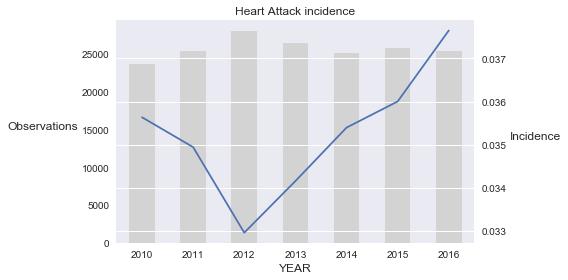

In [18]:
plt.figure(figsize=(8, 4))
plt = plot_pig_table(data, target_variable, "YEAR");
plt.title("Heart Attack incidence")
plt.tight_layout()
plt.savefig('Results\year_vs_tgt')
plt.show();

In [19]:
candidate_variables.extend(["YEAR"])

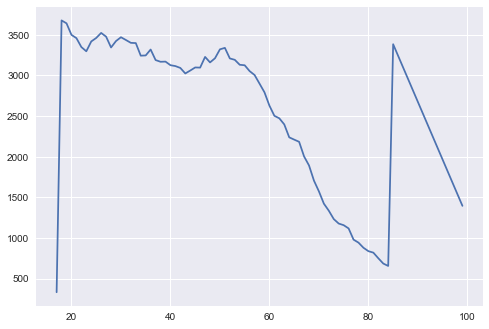

In [20]:
data['AGE'].value_counts().sort_index().plot(kind='line');

In [21]:
#All ages above 85 are regrouped in 85
#Unknowns are coded as 99
data.loc[data['AGE'].isin([96, 97, 98, 99]),'AGE'] = np.nan

#BIRTHYR is treated in the same way. Keep AGE
candidate_variables.extend(["AGE"])

In [22]:
data["AGE"].isna().sum()

1395

In [23]:
#PERWEIGHT technical variable to reweight samples 
data["PERWEIGHT"].describe()

count    179785.000000
mean       9416.623627
std        8351.204369
min           0.000000
25%        3784.611328
50%        6900.357910
75%       12644.689453
max      102133.750000
Name: PERWEIGHT, dtype: float64

In [24]:
data['SEX'].unique()

array([1, 2], dtype=int64)

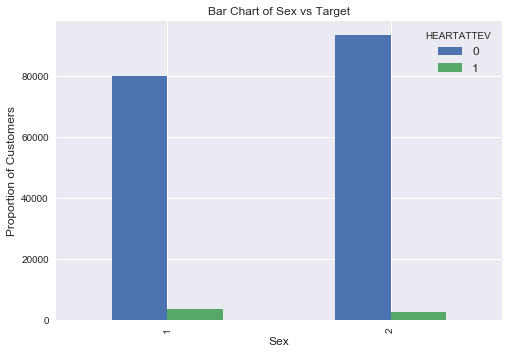

In [25]:
pd.crosstab(data.SEX,data[target_variable]).plot(kind='bar')
plt.title('Bar Chart of Sex vs Target')
plt.xlabel('Sex')
plt.ylabel('Proportion of Customers')
plt.savefig('Results\sex_vs_tgt')

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


<module 'matplotlib.pyplot' from 'C:\\Users\\Karsten\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

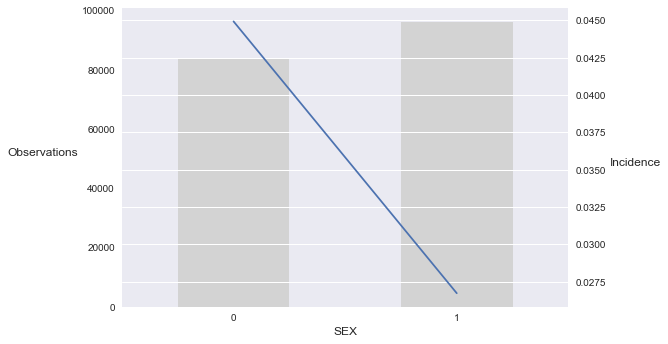

In [26]:
data.loc[data['SEX'] == 1, 'SEX'] = 0
data.loc[data['SEX'] == 2, 'SEX'] = 1
plot_pig_table(data, target_variable, "SEX")

In [27]:
data["SEX"].isna().sum()

0

In [28]:
candidate_variables.extend(["SEX"])

In [29]:
data['MARSTAT'] = data['MARSTAT'].astype('object')
data.loc[data['MARSTAT'] == 10, 'MARSTAT'] = "Married"
data.loc[data['MARSTAT'] == 20, 'MARSTAT'] = "Widowed"
data.loc[data['MARSTAT'] == 30, 'MARSTAT'] = "Divorced"
data.loc[data['MARSTAT'] == 40, 'MARSTAT'] = "Separated"
data.loc[data['MARSTAT'] == 50, 'MARSTAT'] = "Never Married"
data.loc[data['MARSTAT'] == 99, 'MARSTAT'] = "Unknown"

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


<module 'matplotlib.pyplot' from 'C:\\Users\\Karsten\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

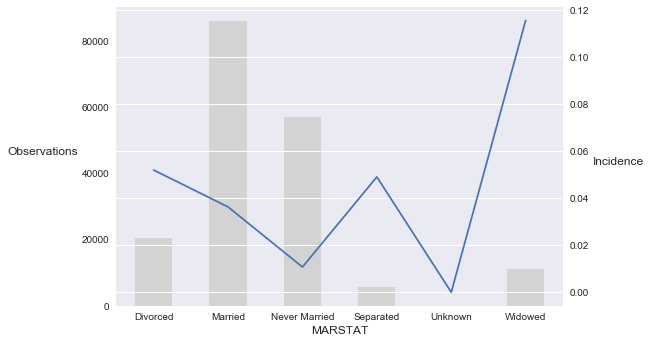

In [30]:
plot_pig_table(data, target_variable, "MARSTAT")

In [31]:
data["MARSTAT"].isna().sum()

0

In [32]:
candidate_variables.extend(["MARSTAT"])

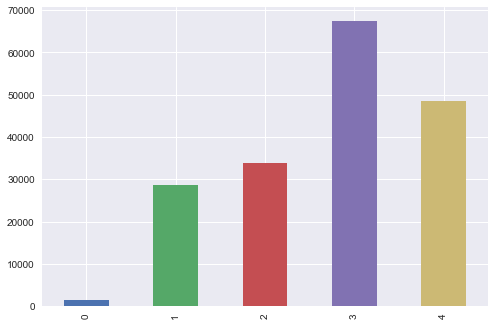

In [33]:
data['REGIONMEPS'].value_counts().sort_index().plot("bar");

In [34]:
data.loc[data['REGIONMEPS'] == 0, "REGIONMEPS"] = 99
data['REGIONMEPS'] = data['REGIONMEPS'].astype('object')

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


<module 'matplotlib.pyplot' from 'C:\\Users\\Karsten\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

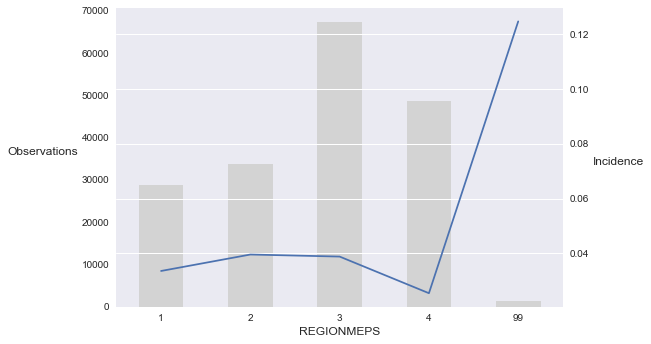

In [35]:
plot_pig_table(data, target_variable, "REGIONMEPS")

In [36]:
candidate_variables.extend(["REGIONMEPS"])

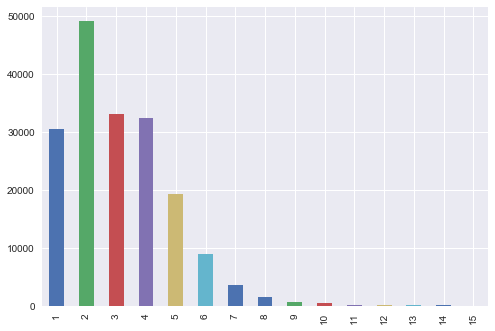

In [37]:
data['FAMSIZE'].value_counts().sort_index().plot("bar");

In [38]:
data["FAMSIZE"].isna().sum()

0

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


<module 'matplotlib.pyplot' from 'C:\\Users\\Karsten\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

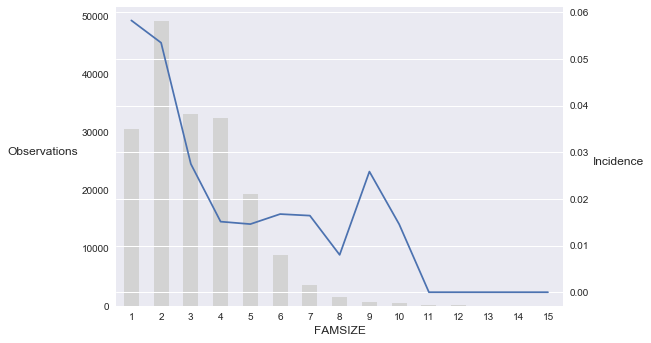

In [39]:
plot_pig_table(data, target_variable, "FAMSIZE")

In [40]:
candidate_variables.extend(["FAMSIZE"])

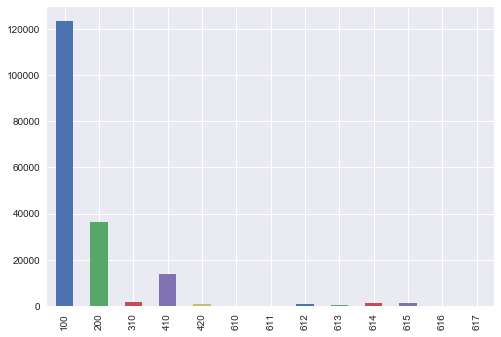

In [41]:
data['RACEA'].value_counts().sort_index().plot("bar");

In [42]:
data["RACEA"].isna().sum()

0

In [43]:
data.loc[~data['RACEA'].isin([100, 200, 310, 410, 614, 615]),'RACEA'] = 999
data['RACEA'] = data['RACEA'].astype('object')
data.loc[data['RACEA'] == 100, 'RACEA'] = "White"
data.loc[data['RACEA'] == 200, 'RACEA'] = "Black"
data.loc[data['RACEA'] == 310, 'RACEA'] = "Native"
data.loc[data['RACEA'] == 410, 'RACEA'] = "Asian"
data.loc[data['RACEA'] == 614, 'RACEA'] = "Mult_BW"
data.loc[data['RACEA'] == 615, 'RACEA'] = "Multi_W"
data.loc[data['RACEA'] == 999, 'RACEA'] = "Unknown"

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


<module 'matplotlib.pyplot' from 'C:\\Users\\Karsten\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

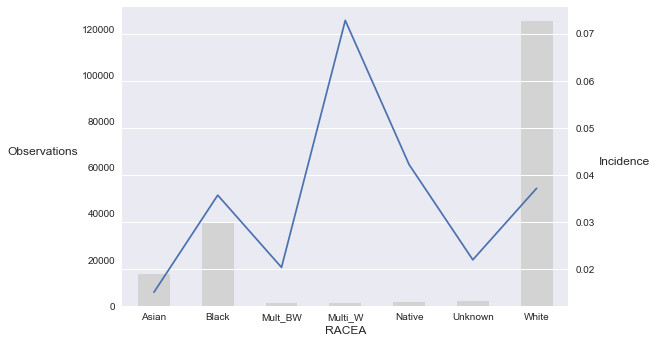

In [44]:
plot_pig_table(data, target_variable, "RACEA")

In [45]:
candidate_variables.extend(["RACEA"])

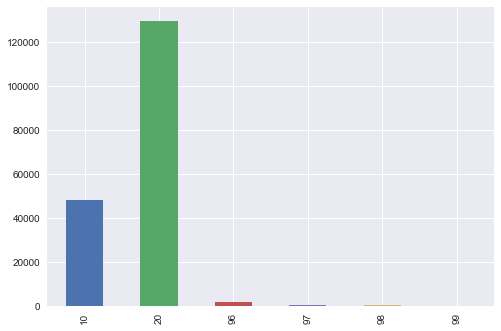

In [46]:
data['USBORN'].value_counts().sort_index().plot("bar");

In [47]:
data["USBORN"].isna().sum()

0

In [48]:
data.loc[~data['USBORN'].isin([10, 20]),'USBORN'] = 99
data['USBORN'] = data['USBORN'].astype('object')
data.loc[data['USBORN'] == 10, 'USBORN'] = "No"
data.loc[data['USBORN'] == 20, 'USBORN'] = "Yes"
data.loc[data['USBORN'] == 99, 'USBORN'] = "Unknown"

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


<module 'matplotlib.pyplot' from 'C:\\Users\\Karsten\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

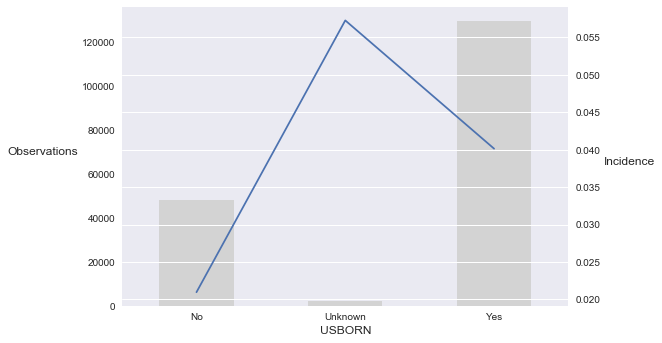

In [49]:
plot_pig_table(data, target_variable, "USBORN")

In [50]:
candidate_variables.extend(["USBORN"])

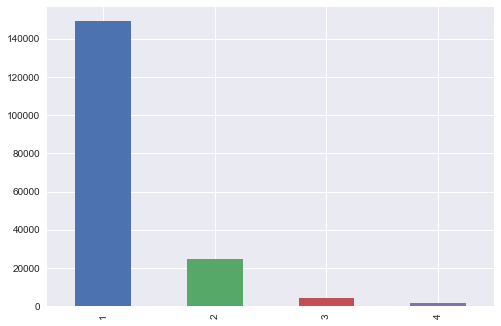

In [51]:
data['INTERVLANG'].value_counts().sort_index().plot("bar");

In [52]:
data['INTERVLANG'] = data['INTERVLANG'].astype('object')
data["INTERVLANG"].isna().sum()

0

In [53]:
data.loc[data['INTERVLANG'] == 1, 'INTERVLANG'] = "Eng"
data.loc[data['INTERVLANG'] == 2, 'INTERVLANG'] = "Sp"
data.loc[data['INTERVLANG'] == 3, 'INTERVLANG'] = "Eng_Sp"
data.loc[data['INTERVLANG'] == 4, 'INTERVLANG'] = "Unknown"

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


<module 'matplotlib.pyplot' from 'C:\\Users\\Karsten\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

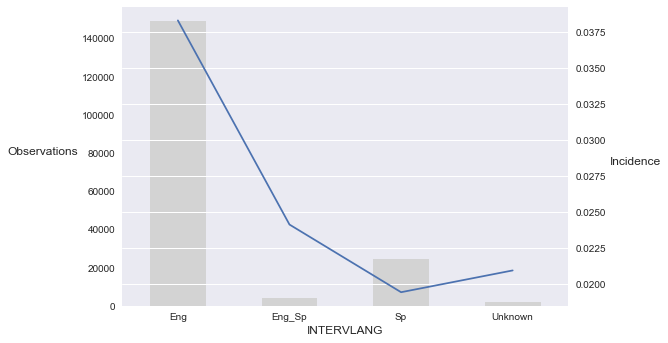

In [54]:
plot_pig_table(data, target_variable, "INTERVLANG")

In [55]:
candidate_variables.extend(["INTERVLANG"])

FILESTATUS: Status in latest tax file (Single, Married etc.)

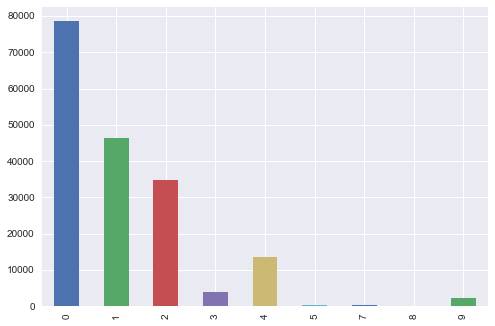

In [56]:
data['FILESTATUS'].value_counts().sort_index().plot("bar");

In [57]:
data['FILESTATUS'] = data['FILESTATUS'].astype('object')
data["FILESTATUS"].isna().sum()

0

In [58]:
data.loc[~data['FILESTATUS'].isin([1, 2, 3, 4]),'FILESTATUS'] = "Unknown"
data.loc[data['FILESTATUS'] == 1, 'FILESTATUS'] = "Single"
data.loc[data['FILESTATUS'] == 2, 'FILESTATUS'] = "Married_joint"
data.loc[data['FILESTATUS'] == 3, 'FILESTATUS'] = "Married_sep"
data.loc[data['FILESTATUS'] == 4, 'FILESTATUS'] = "Head_wq"

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


<module 'matplotlib.pyplot' from 'C:\\Users\\Karsten\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

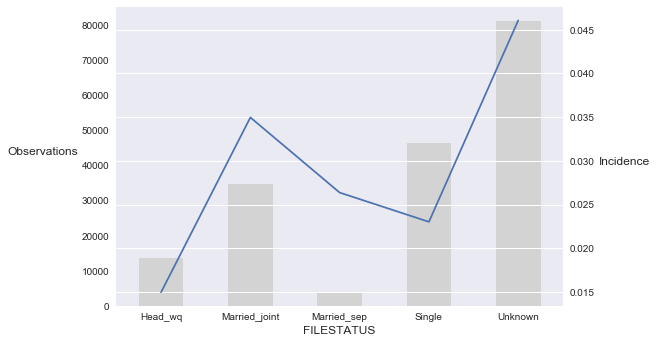

In [59]:
plot_pig_table(data, target_variable, "FILESTATUS")

In [60]:
candidate_variables.extend(["FILESTATUS"])

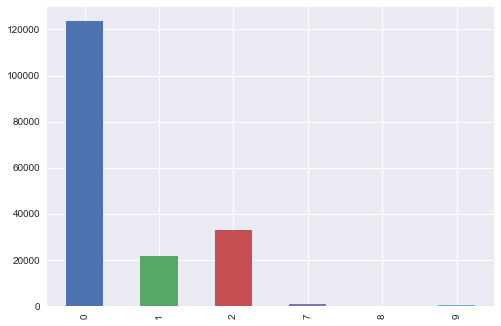

In [61]:
data['WORKEV'].value_counts().sort_index().plot("bar");

In [62]:
data['WORKEV'] = data['WORKEV'].astype('object')
data["WORKEV"].isna().sum()

0

In [63]:
data.loc[~data['WORKEV'].isin([1, 2]),'WORKEV'] = "Unknown"
data.loc[data['WORKEV'] == 1, 'WORKEV'] = "No"
data.loc[data['WORKEV'] == 2, 'WORKEV'] = "Yes"

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


<module 'matplotlib.pyplot' from 'C:\\Users\\Karsten\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

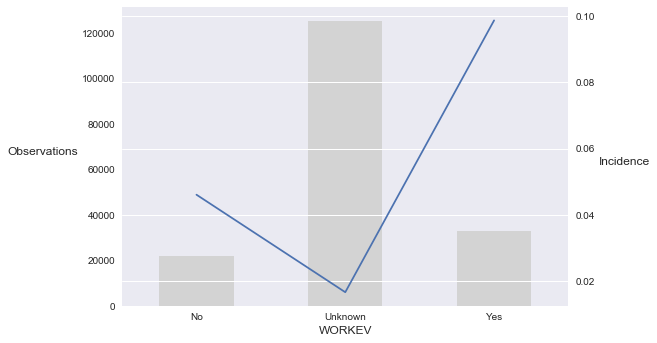

In [64]:
plot_pig_table(data, target_variable, "WORKEV")

In [65]:
# Question only asked to those who didnt indicate current employment in prior questions
candidate_variables.extend(["WORKEV"])

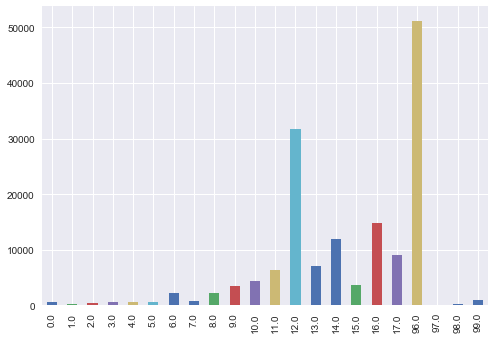

In [66]:
data['EDUCYR'].value_counts().sort_index().plot("bar");
#review if correlation high enough to just use one of two

In [67]:
data["EDUCYR"].isna().sum()

26499

In [68]:
# regroup different types of unknown. Treat variable as numeric therefore keep as missing
# integer variable canont handle empty, keep as float
data.loc[data['EDUCYR'].isin([96, 97, 98, 99]),'EDUCYR'] = np.nan

In [69]:
data["EDUCYR"].isna().sum()

79035

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


<module 'matplotlib.pyplot' from 'C:\\Users\\Karsten\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

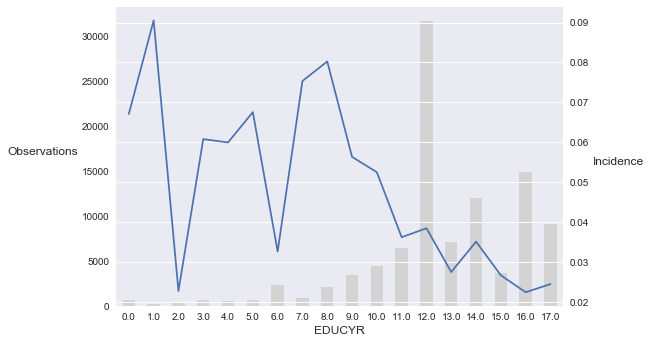

In [70]:
plot_pig_table(data, target_variable, "EDUCYR")

In [71]:
candidate_variables.extend(["EDUCYR"])

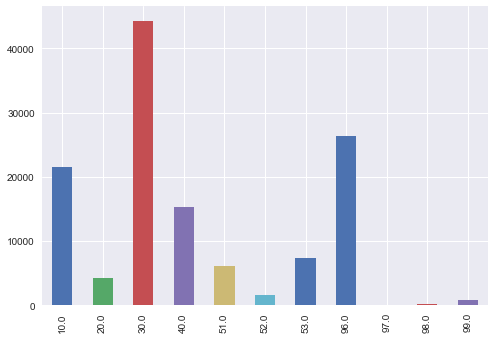

In [72]:
data['HIDEG'].value_counts().sort_index().plot("bar");

In [73]:
data["HIDEG"].isna().sum()

51560

In [74]:
# regroup different types of unknown. Treat as categorical variable, therefore replace with 99
data.loc[data['HIDEG'].isna(), 'HIDEG'] = 99
data['HIDEG'] = data['HIDEG'].astype(int)
data.loc[data['HIDEG'].isin([96, 97, 98, 99]),'HIDEG'] = 99
data['HIDEG'] = data['HIDEG'].astype('object')
data.loc[data['HIDEG'] == 10, 'HIDEG'] = "1_No degree"
data.loc[data['HIDEG'] == 20, 'HIDEG'] = "2_GED"
data.loc[data['HIDEG'] == 30, 'HIDEG'] = "3_High school"
data.loc[data['HIDEG'] == 40, 'HIDEG'] = "4_Bachelor"
data.loc[data['HIDEG'] == 51, 'HIDEG'] = "5_Master"
data.loc[data['HIDEG'] == 52, 'HIDEG'] = "6_Doctorate"
data.loc[data['HIDEG'] == 53, 'HIDEG'] = "7_Other"
data.loc[data['HIDEG'] == 99, 'HIDEG'] = "8_Unknown"

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


<module 'matplotlib.pyplot' from 'C:\\Users\\Karsten\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

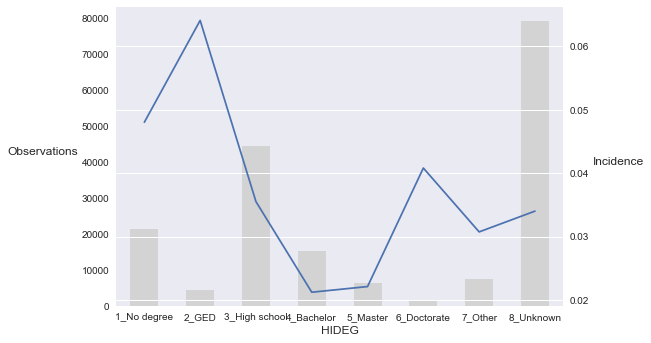

In [75]:
plot_pig_table(data, target_variable, "HIDEG")

In [76]:
data["HIDEG"].isna().sum()

0

In [77]:
candidate_variables.extend(["HIDEG"])

In [78]:
data["INCTOT"].describe()

count    179785.000000
mean      29824.530645
std       33950.942183
min     -204643.000000
25%        8088.000000
50%       20000.000000
75%       40000.000000
max      731652.960000
Name: INCTOT, dtype: float64

In [79]:
data["INCTOT"].isna().sum()

0

In [80]:
data["FTOTVAL"].describe()

count    179785.000000
mean      61156.177518
std       57114.272213
min     -258220.000000
25%       21855.000000
50%       45000.000000
75%       82930.000000
max      731653.000000
Name: FTOTVAL, dtype: float64

In [81]:
data["FTOTVAL"].isna().sum()

0

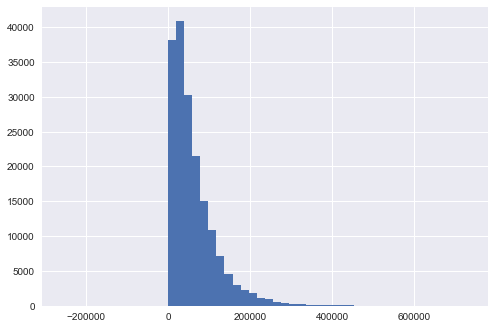

In [82]:
data["FTOTVAL"].hist(bins=50);

In [83]:
data.loc[data["FTOTVAL"]<-10000, "FTOTVAL"].size

35

In [84]:
#only few outliers with large negative total value. Limit to -10000
data.loc[data["FTOTVAL"]<-10000, "FTOTVAL"] = -10000

In [85]:
candidate_variables.extend(["FTOTVAL"])

POVLEV: Family income as a % of poverty line

In [86]:
data["POVLEV"].describe()

count    179785.000000
mean        330.748285
std         307.941344
min       -1638.979968
25%         125.650000
50%         244.040000
75%         438.660000
max        5859.789824
Name: POVLEV, dtype: float64

In [87]:
data["POVLEV"].isna().sum()

0

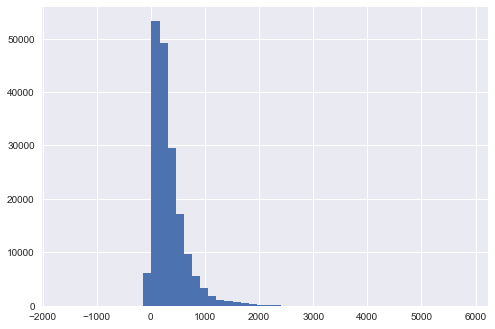

In [88]:
data["POVLEV"].hist(bins=50);

In [89]:
candidate_variables.extend(["POVLEV"])

In [90]:
data['DIABETICEV'].value_counts()

1    160998
2     18755
9        27
7         5
Name: DIABETICEV, dtype: int64

In [91]:
data.loc[data['DIABETICEV'].isin([1, 7, 9]),'DIABETICEV'] = 0
data.loc[data['DIABETICEV'] == 2,'DIABETICEV'] = 1

In [92]:
data["DIABETICEV"].isna().sum()

0

In [93]:
pd.crosstab(data["DIABETICEV"], data["HEARTATTEV"])

HEARTATTEV,0,1
DIABETICEV,,
0,157011,4019
1,16445,2310


C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  import sys


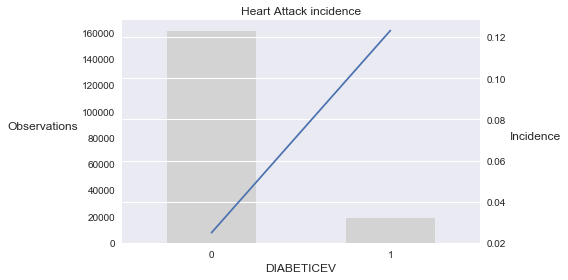

In [94]:
plt.figure(figsize=(8, 4))
plt = plot_pig_table(data, target_variable, "DIABETICEV")
plt.title("Heart Attack incidence")
plt.tight_layout()
plt.savefig('Results\diab_vs_tgt')
plt.show();

In [95]:
groups = data[[target_variable,"DIABETICEV"]].groupby("DIABETICEV")
groups[target_variable].agg({'Incidence' : np.mean, 'Observations' : np.size})

C:\Users\Karsten\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,Incidence,Observations
DIABETICEV,,
0,0.024958,161030
1,0.123167,18755


In [96]:
data['DIABETICEV'] = data['DIABETICEV'].astype('int64')

In [97]:
candidate_variables.extend(["DIABETICEV"])

In [98]:
candidate_variables
#candidate_variables = ['YEAR', 'PERWEIGHT', 'SAQWEIGHT', 'AGE', 'SEX', 'MARSTAT', 'EDUCYR', 'HIDEG', 'INCTOT', 'FTOTVAL', 'DIABETICEV']

['YEAR',
 'AGE',
 'SEX',
 'MARSTAT',
 'REGIONMEPS',
 'FAMSIZE',
 'RACEA',
 'USBORN',
 'INTERVLANG',
 'FILESTATUS',
 'WORKEV',
 'EDUCYR',
 'HIDEG',
 'FTOTVAL',
 'POVLEV',
 'DIABETICEV']

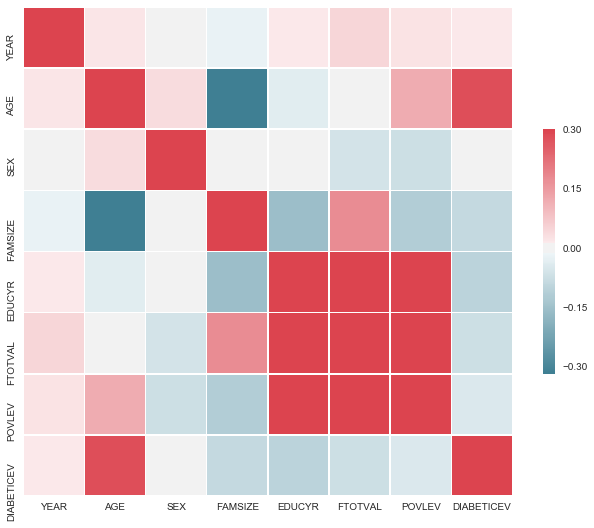

In [99]:
#sns.set(style="white")

# Compute the correlation matrix
corr = data[candidate_variables].corr()

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [100]:
total = data[candidate_variables]
Label = data[target_variable]

In [101]:
total.shape

(179785, 16)

In [102]:
cat_features = [total.columns[i] for i, j in enumerate(total.dtypes) if (j == "object" or j == "bool")]
numeric_features = [total.columns[i] for i, j in enumerate(total.dtypes) if j in ["int64", "float64"]]

In [103]:
cat_features

['MARSTAT',
 'REGIONMEPS',
 'RACEA',
 'USBORN',
 'INTERVLANG',
 'FILESTATUS',
 'WORKEV',
 'HIDEG']

In [104]:
numeric_features

['YEAR', 'AGE', 'SEX', 'FAMSIZE', 'EDUCYR', 'FTOTVAL', 'POVLEV', 'DIABETICEV']

In [105]:
#sns.pairplot(data[numeric_features].dropna());

# Dummy variables

In [106]:
total_cat = total[cat_features]
total_num = total[numeric_features]
for var in cat_features:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(total_cat[var], prefix=var)
    data1=total_cat.join(cat_list)
    total_cat=data1

In [107]:
# exclude DIABETICEV and SEX from scaling as already one-hot encoded
total_cat=pd.concat([total_cat, total['DIABETICEV'], total['SEX']], axis=1)
total_num=total_num.drop(['DIABETICEV', 'SEX'], axis=1)
total_cat.head()

,MARSTAT,REGIONMEPS,RACEA,USBORN,INTERVLANG,FILESTATUS,WORKEV,HIDEG,MARSTAT_Divorced,MARSTAT_Married,...,HIDEG_1_No degree,HIDEG_2_GED,HIDEG_3_High school,HIDEG_4_Bachelor,HIDEG_5_Master,HIDEG_6_Doctorate,HIDEG_7_Other,HIDEG_8_Unknown,DIABETICEV,SEX
0,Married,1,White,No,Sp,Head_wq,Unknown,7_Other,0,1,...,0,0,0,0,0,0,1,0,0,0
1,Married,1,White,No,Sp,Unknown,Yes,3_High school,0,1,...,0,0,1,0,0,0,0,0,0,1
2,Married,4,Unknown,No,Eng,Married_joint,Unknown,6_Doctorate,0,1,...,0,0,0,0,0,1,0,0,0,0
3,Married,4,Asian,No,Eng,Unknown,Unknown,5_Master,0,1,...,0,0,0,0,1,0,0,0,0,1
4,Never Married,1,Black,Yes,Eng,Unknown,Unknown,8_Unknown,0,0,...,0,0,0,0,0,0,0,1,0,1


In [108]:
total_cat.columns

Index(['MARSTAT', 'REGIONMEPS', 'RACEA', 'USBORN', 'INTERVLANG', 'FILESTATUS',
       'WORKEV', 'HIDEG', 'MARSTAT_Divorced', 'MARSTAT_Married',
       'MARSTAT_Never Married', 'MARSTAT_Separated', 'MARSTAT_Unknown',
       'MARSTAT_Widowed', 'REGIONMEPS_1', 'REGIONMEPS_2', 'REGIONMEPS_3',
       'REGIONMEPS_4', 'REGIONMEPS_99', 'RACEA_Asian', 'RACEA_Black',
       'RACEA_Mult_BW', 'RACEA_Multi_W', 'RACEA_Native', 'RACEA_Unknown',
       'RACEA_White', 'USBORN_No', 'USBORN_Unknown', 'USBORN_Yes',
       'INTERVLANG_Eng', 'INTERVLANG_Eng_Sp', 'INTERVLANG_Sp',
       'INTERVLANG_Unknown', 'FILESTATUS_Head_wq', 'FILESTATUS_Married_joint',
       'FILESTATUS_Married_sep', 'FILESTATUS_Single', 'FILESTATUS_Unknown',
       'WORKEV_No', 'WORKEV_Unknown', 'WORKEV_Yes', 'HIDEG_1_No degree',
       'HIDEG_2_GED', 'HIDEG_3_High school', 'HIDEG_4_Bachelor',
       'HIDEG_5_Master', 'HIDEG_6_Doctorate', 'HIDEG_7_Other',
       'HIDEG_8_Unknown', 'DIABETICEV', 'SEX'],
      dtype='object')

# Missing values

In [109]:
# check variables that are missing
for j in range(total_num.values.shape[1]):
    vec = total_num.values[:,j]
    mask = np.isfinite(vec)
    if np.sum(~mask) > 0:
        print(j, total_num.columns[j])
        print(np.sum(~mask))

1 AGE
1395
3 EDUCYR
79035


In [110]:
imp = SimpleImputer(missing_values=np.nan, strategy='median')
imp.fit(total_num)
total_num_temp= imp.transform(total_num)

# Scaling

In [111]:
standardize = StandardScaler(copy=True, with_mean=True, with_std=True)
total_num_temp = standardize.fit_transform(total_num_temp)

In [112]:
total_num = pd.DataFrame(total_num_temp, columns = total_num.columns)
total_num.head()

,YEAR,AGE,FAMSIZE,EDUCYR,FTOTVAL,POVLEV
0,-1.52997,-0.924532,0.525629,0.693982,0.102221,-0.090142
1,-1.52997,-1.094283,0.525629,0.693982,0.102221,-0.090142
2,-1.52997,0.376892,-0.060812,1.975595,0.529910,0.617333
3,-1.52997,0.490060,-0.060812,1.975595,0.529910,0.617333
4,-1.52997,0.942729,-1.233693,-0.160426,-0.730108,-0.516555


# Metrics

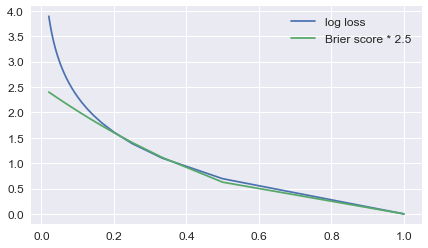

In [113]:
y_true=[1,1]
logl = []
BS = []
y_pred=[]
for i in range(1,50):
    logl.append(log_loss(y_true,[1/i, 1/i], labels=[0,1]))
    BS.append(2.5*brier_score_loss([1], [1-1/i]))
    y_pred.append(1/i)
    
plt.figure(figsize=(7, 4))
plt.plot(y_pred, logl, label="log loss")
plt.plot(y_pred, BS, label="Brier score * 2.5")
plt.legend(fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.savefig('metrics')

# Dataset

In [114]:
total = pd.concat([total_num, total_cat], axis=1, sort=True)
total = total.drop(['MARSTAT', 'HIDEG', 'REGIONMEPS', 'RACEA', 'USBORN', 'INTERVLANG', 'FILESTATUS', 'WORKEV'], axis=1)
total.shape

(179785, 49)

# Train-test

In [115]:
X_train, X_test, y_train, y_test = train_test_split(total, Label, random_state=0)

In [116]:
y_train.value_counts().sort_index()

0    130168
1      4670
Name: HEARTATTEV, dtype: int64

In [117]:
y_test.value_counts().sort_index()

0    43288
1     1659
Name: HEARTATTEV, dtype: int64

# K-fold

In [118]:
num_folds = 5
seed = 7

kfold = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)

# Logistic Regression - Forward selection

In [119]:
# remove one category (null)
X_train_LR = X_train.drop(['MARSTAT_Unknown', 'HIDEG_8_Unknown', 'REGIONMEPS_99', 'RACEA_Unknown', 'USBORN_Unknown', 'INTERVLANG_Unknown', 'FILESTATUS_Unknown', 'WORKEV_Unknown'], axis=1)
X_test_LR = X_test.drop(['MARSTAT_Unknown', 'HIDEG_8_Unknown', 'REGIONMEPS_99', 'RACEA_Unknown', 'USBORN_Unknown', 'INTERVLANG_Unknown', 'FILESTATUS_Unknown', 'WORKEV_Unknown'], axis=1)
basetable = pd.concat([X_train_LR, y_train], axis=1)
variables = list(X_train_LR.columns.values)

In [120]:
basetable.head()

,YEAR,AGE,FAMSIZE,EDUCYR,FTOTVAL,POVLEV,MARSTAT_Divorced,MARSTAT_Married,MARSTAT_Never Married,MARSTAT_Separated,...,HIDEG_1_No degree,HIDEG_2_GED,HIDEG_3_High school,HIDEG_4_Bachelor,HIDEG_5_Master,HIDEG_6_Doctorate,HIDEG_7_Other,DIABETICEV,SEX,HEARTATTEV
87489,-0.008401,-1.264034,-0.060812,-0.160426,-1.044938,-1.033863,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
71069,-0.515591,-1.264034,-0.647252,-0.160426,-0.703417,-0.643138,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
121339,0.498788,0.829562,-0.647252,-0.160426,-0.274537,-0.142262,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
43066,-1.022780,-0.415279,-1.233693,0.266778,-0.615322,-0.351718,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
160043,1.513167,1.338815,-1.233693,-2.723652,-0.547369,-0.230266,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0


In [121]:
basetable.columns

Index(['YEAR', 'AGE', 'FAMSIZE', 'EDUCYR', 'FTOTVAL', 'POVLEV',
       'MARSTAT_Divorced', 'MARSTAT_Married', 'MARSTAT_Never Married',
       'MARSTAT_Separated', 'MARSTAT_Widowed', 'REGIONMEPS_1', 'REGIONMEPS_2',
       'REGIONMEPS_3', 'REGIONMEPS_4', 'RACEA_Asian', 'RACEA_Black',
       'RACEA_Mult_BW', 'RACEA_Multi_W', 'RACEA_Native', 'RACEA_White',
       'USBORN_No', 'USBORN_Yes', 'INTERVLANG_Eng', 'INTERVLANG_Eng_Sp',
       'INTERVLANG_Sp', 'FILESTATUS_Head_wq', 'FILESTATUS_Married_joint',
       'FILESTATUS_Married_sep', 'FILESTATUS_Single', 'WORKEV_No',
       'WORKEV_Yes', 'HIDEG_1_No degree', 'HIDEG_2_GED', 'HIDEG_3_High school',
       'HIDEG_4_Bachelor', 'HIDEG_5_Master', 'HIDEG_6_Doctorate',
       'HIDEG_7_Other', 'DIABETICEV', 'SEX', 'HEARTATTEV'],
      dtype='object')

In [122]:
max_number_variables = 8
number_iterations = min(max_number_variables, len(variables))
current_variables = []
score = []
for i in range(0,number_iterations):
    next_var, sc = next_best(current_variables, variables, [target_variable], basetable)
    current_variables = current_variables + [next_var]
    score = score + [sc]
    variables.remove(next_var)
print(current_variables)

0.12927989304769638
0.12591255665392873
0.1241695771398454
0.12291895795559293
0.12189432792563187
0.1215212952020133
0.12119418551367458
0.12086569992599992
['AGE', 'DIABETICEV', 'SEX', 'FTOTVAL', 'USBORN_No', 'FILESTATUS_Single', 'WORKEV_Yes', 'WORKEV_No']


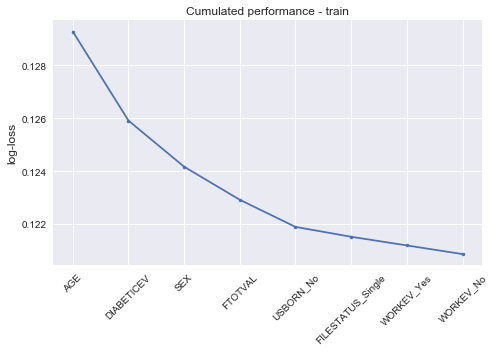

In [123]:
plt.figure(figsize=(7, 5))
plt.plot(score, marker='.')
plt.ylabel('log-loss')
plt.title('Cumulated performance - train')
plt.xticks(range(len(current_variables)), current_variables, rotation=45)
plt.tight_layout()
plt.savefig('Results\LRforward')
plt.show()

In [124]:
logreg = linear_model.LogisticRegression(solver='lbfgs', max_iter = 300)

In [125]:
logreg.fit(basetable[current_variables],basetable[target_variable])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=300, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [126]:
scores = cross_val_score(logreg, basetable[current_variables],basetable[target_variable], cv=5, scoring='neg_log_loss')
-scores

array([0.12146211, 0.12160567, 0.12081336, 0.12020679, 0.1206482 ])

In [127]:
y_pred_train = logreg.predict_proba(X_train_LR[current_variables])
y_pred_test = logreg.predict_proba(X_test_LR[current_variables])
print("Train AUC: ", roc_auc_score(y_train, y_pred_train[:,1]))
print("Train logloss: ", log_loss(y_train, y_pred_train[:,1]))
print("Test AUC: ", roc_auc_score(y_test, y_pred_test[:,1]))
print("Test logloss: ", log_loss(y_test, y_pred_test[:,1]))

Train AUC:  0.8525062826073424
Train logloss:  0.12086569992599992
Test AUC:  0.8554945546594357
Test logloss:  0.12619634222116966


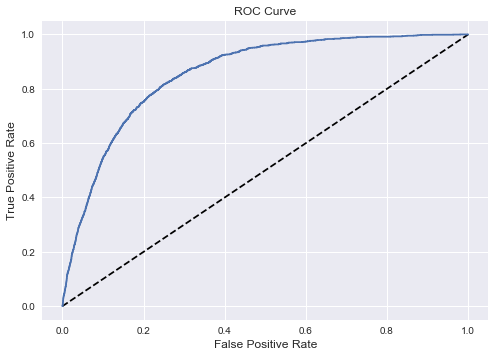

In [128]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [129]:
np.exp(logreg.coef_)

array([[2.49849958, 2.64313011, 0.46420488, 0.73909148, 0.51805744,
        0.72766306, 1.70824555, 1.65425983]])

In [130]:
basetable[current_variables].head()

,AGE,DIABETICEV,SEX,FTOTVAL,USBORN_No,FILESTATUS_Single,WORKEV_Yes,WORKEV_No
87489,-1.264034,0,0,-1.044938,0,1,0,0
71069,-1.264034,0,1,-0.703417,0,1,0,0
121339,0.829562,0,1,-0.274537,0,0,0,0
43066,-0.415279,0,0,-0.615322,0,1,0,0
160043,1.338815,1,1,-0.547369,1,0,1,0


In [131]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,basetable[current_variables])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.228685
         Iterations 8
                          Results: Logit
Model:                Logit            Pseudo R-squared: -0.520    
Dependent Variable:   HEARTATTEV       AIC:              61686.8160
Date:                 2019-01-12 14:28 BIC:              61765.3107
No. Observations:     134838           Log-Likelihood:   -30835.   
Df Model:             7                LL-Null:          -20293.   
Df Residuals:         134830           LLR p-value:      1.0000    
Converged:            1.0000           Scale:            1.0000    
No. Iterations:       8.0000                                       
-------------------------------------------------------------------
                   Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-------------------------------------------------------------------
AGE                0.7610   0.0129   58.8280 0.0000  0.7356  0.7863
DIABETICEV        -0.3066   0.0329   -9.3

In [132]:
conf_matrix = confusion_matrix(y_test, logreg.predict(X_test[current_variables]))
print(conf_matrix)

[[43279     9]
 [ 1658     1]]


# Logistic Regression - Grid search

In [133]:
c_space = np.logspace(-4, 1, 20)

param_grid_logreg = {
    'C': [0.15],
    'penalty': ["l1"]
}

param_grid_logreg_bk = {
    'C': c_space,
    'penalty': ["l1", "l2"]
}

In [134]:
logreg2 = linear_model.LogisticRegression(solver='liblinear') #'lbfgs')
grid_logreg = GridSearchCV(logreg2, param_grid_logreg, cv=kfold, scoring={'neg_log_loss','brier_score_loss'}, refit='neg_log_loss', error_score='raise')
grid_logreg.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.15], 'penalty': ['l1']},
       pre_dispatch='2*n_jobs', refit='neg_log_loss',
       return_train_score='warn',
       scoring={'neg_log_loss', 'brier_score_loss'}, verbose=0)

In [135]:
means = -grid_logreg.cv_results_['mean_test_neg_log_loss']
stds = grid_logreg.cv_results_['std_test_neg_log_loss']
for mean, std, params in zip(means, stds, grid_logreg.cv_results_['params']):
   print("%0.5f (+/-%0.05f) for %r"
   % (mean, std * 2, params))

0.11885 (+/-0.00118) for {'C': 0.15, 'penalty': 'l1'}


In [136]:
results = pd.concat([pd.DataFrame.from_dict(grid_logreg.cv_results_['params']), pd.DataFrame.from_dict(grid_logreg.cv_results_['mean_test_neg_log_loss']), pd.DataFrame.from_dict(grid_logreg.cv_results_['std_test_neg_log_loss'])], axis=1)
results.columns = ['C', 'penalty', 'mean_test_neg_log_loss', 'std_test_neg_log_loss']

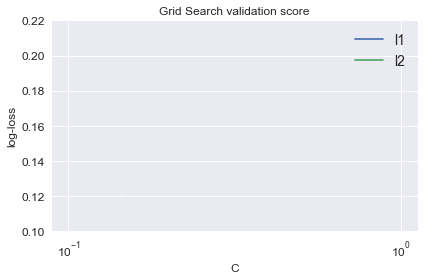

In [137]:
l1 = results.loc[results['penalty'] == 'l1']
l2 = results.loc[results['penalty'] == 'l2']

plt.figure(figsize=(6, 4))
plt.semilogx(l1['C'], -l1['mean_test_neg_log_loss'], label='l1')
plt.gca().fill_between(l1['C'], -l1['mean_test_neg_log_loss'] - l1['std_test_neg_log_loss'], -l1['mean_test_neg_log_loss'] + l1['std_test_neg_log_loss'],
                       alpha=0.2, color='blue')
plt.semilogx(l2['C'], -l2['mean_test_neg_log_loss'], label='l2')
plt.gca().fill_between(l2['C'], -l2['mean_test_neg_log_loss'] - l2['std_test_neg_log_loss'], -l2['mean_test_neg_log_loss'] + l2['std_test_neg_log_loss'],
                       alpha=0.2, color='green')
plt.yticks([0.10, 0.12, 0.14, 0.16, 0.18, 0.20, 0.22])
plt.title('Grid Search validation score')
plt.xlabel('C')
plt.ylabel('log-loss')
plt.legend(loc='best', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig('Results/LRGrid')
plt.show();

In [138]:
logreg = grid_logreg.best_estimator_
logreg

LogisticRegression(C=0.15, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [139]:
y_pred_test = grid_logreg.predict_proba(X_test)
print("Train logloss: ", -grid_logreg.cv_results_['mean_test_neg_log_loss'])
print("Train Brier Score: ", -grid_logreg.cv_results_['mean_test_brier_score_loss'])

print("Test AUC: ", roc_auc_score(y_test, y_pred_test[:,1]))
print("Test logloss: ", log_loss(y_test, y_pred_test[:,1]))
print("Test Brier Score: ", brier_score_loss(y_test, y_pred_test[:,1], pos_label=1))

Train logloss:  [0.11885066]
Train Brier Score:  [0.03058467]
Test AUC:  0.8593287856351377
Test logloss:  0.12484175027850275
Test Brier Score:  0.032456968747210074


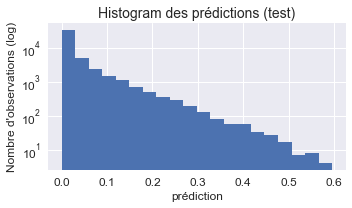

In [140]:
plt.figure(figsize=(5,3))
plt.hist(y_pred_test[:,1], bins=20, log=True)
plt.title('Histogram des prédictions (test)', fontsize=14)
plt.xlabel('prédiction', fontsize=12)
plt.ylabel("Nombre d'observations (log)")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig('Results/LRHist');
plt.show;

In [141]:
fop, mpv = calibration_curve(y_test, y_pred_test[:,1], n_bins=10)

In [142]:
I = pd.Index(["LogReg_true", "LogReg_pred"])
calib_curves = pd.DataFrame([fop, mpv], index = I)
calib_curves

,0,1,2,3,4,5
LogReg_true,0.021077,0.154445,0.225501,0.283088,0.301887,0.30000
LogReg_pred,0.018395,0.139213,0.243059,0.339597,0.440382,0.54071


In [143]:
bin_total(y_test, y_pred_test[:,1], n_bins=10)

array([40518,  3082,   949,   272,   106,    20,     0,     0,     0,
           0,     0], dtype=int64)

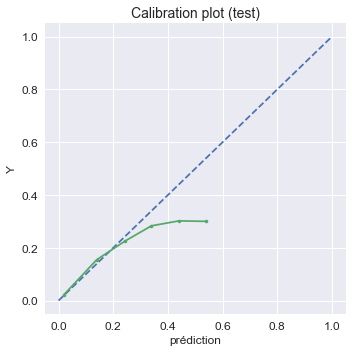

In [144]:
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(mpv, fop, marker='.')
plt.title('Calibration plot (test)', fontsize=14)
plt.xlabel('prédiction', fontsize=12)
plt.ylabel('Y')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig('Results/LRCalib');
plt.show()

In [145]:
coeff = pd.DataFrame({'feature': X_train.columns, 'coef': np.exp(grid_logreg.best_estimator_.coef_.flatten())})
coeff.to_excel("Results/LogReg_coeff.xls", index = True)

In [146]:
results = pd.DataFrame({'true': y_test, 'predictions': y_pred_test[:,1]})
results = pd.concat([X_test, results], axis=1)
#results.to_excel("Results/out_LogReg.xls", index = True)

In [147]:
results.shape

(44947, 51)

# XGBoost

In [148]:
param_grid_xgb = {
    'max_depth': [5],
    'min_child_weight': [10],
    'n_estimators': [100],
    'learning_rate': [0.1],
    'gamma': [0],
    'subsample': [1],
    'colsample_bytree': [1]
    }

In [149]:
m_XGB = xgb.XGBClassifier()
grid_XGB = GridSearchCV(m_XGB, param_grid_xgb, cv=kfold, scoring={'neg_log_loss','brier_score_loss'}, refit='neg_log_loss')
grid_XGB.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [5], 'min_child_weight': [10], 'n_estimators': [100], 'learning_rate': [0.1], 'gamma': [0], 'subsample': [1], 'colsample_bytree': [1]},
       pre_dispatch='2*n_jobs', refit='neg_log_loss',
       return_train_score='warn',
       scoring={'neg_log_loss', 'brier_score_loss'}, verbose=0)

In [150]:
X_train.head()

,YEAR,AGE,FAMSIZE,EDUCYR,FTOTVAL,POVLEV,MARSTAT_Divorced,MARSTAT_Married,MARSTAT_Never Married,MARSTAT_Separated,...,HIDEG_1_No degree,HIDEG_2_GED,HIDEG_3_High school,HIDEG_4_Bachelor,HIDEG_5_Master,HIDEG_6_Doctorate,HIDEG_7_Other,HIDEG_8_Unknown,DIABETICEV,SEX
87489,-0.008401,-1.264034,-0.060812,-0.160426,-1.044938,-1.033863,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
71069,-0.515591,-1.264034,-0.647252,-0.160426,-0.703417,-0.643138,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
121339,0.498788,0.829562,-0.647252,-0.160426,-0.274537,-0.142262,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
43066,-1.022780,-0.415279,-1.233693,0.266778,-0.615322,-0.351718,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
160043,1.513167,1.338815,-1.233693,-2.723652,-0.547369,-0.230266,0,0,0,0,...,1,0,0,0,0,0,0,0,1,1


In [151]:
grid_XGB.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=10, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [152]:
means = -grid_XGB.cv_results_['mean_test_neg_log_loss']
stds = -grid_XGB.cv_results_['std_test_neg_log_loss']
for mean, std, params in zip(means, stds, grid_XGB.cv_results_['params']):
   print("%0.4f (+/-%0.04f) for %r"
   % (mean, std * 2, params))

0.1161 (+/--0.0003) for {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'subsample': 1}


In [153]:
y_pred = grid_XGB.predict_proba(X_test)

print("Train logloss: ", -grid_XGB.cv_results_['mean_test_neg_log_loss'])
print("Train Brier Score: ", -grid_XGB.cv_results_['mean_test_brier_score_loss'])

print("Test AUC: ", roc_auc_score(y_test, y_pred[:,1]))
print("Test logloss: ", log_loss(y_test, y_pred[:,1]))
print("Test Brier Score: ", brier_score_loss(y_test, y_pred[:,1], pos_label=1))

Train logloss:  [0.11606131]
Train Brier Score:  [0.03015024]
Test AUC:  0.8678269373808114
Test logloss:  0.12204104432316955
Test Brier Score:  0.03210803495964561


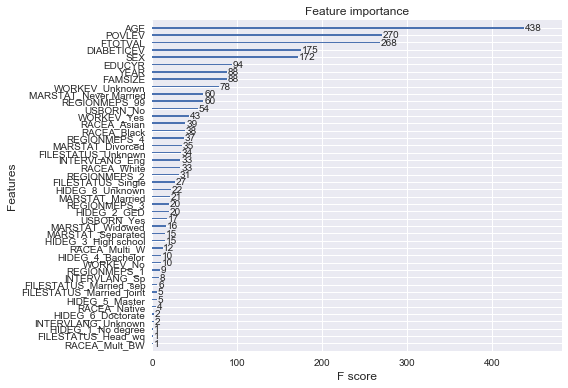

In [154]:
ax = xgb.plot_importance(grid_XGB.best_estimator_)
fig = ax.figure
fig.tight_layout()
fig.savefig('Results/XGBFI');

In [155]:
conf_matrix = confusion_matrix(y_test, grid_XGB.best_estimator_.predict(X_test))
print(conf_matrix)

[[43285     3]
 [ 1657     2]]


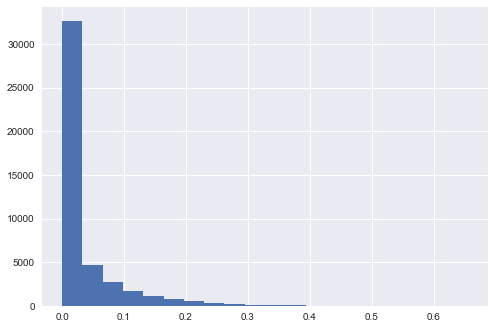

In [156]:
plt.hist(y_pred[:,1], bins=20);

In [157]:
fop, mpv = calibration_curve(y_test, y_pred[:,1], n_bins=10)
bin_total(y_test, y_pred[:,1], n_bins=10)

array([40125,  3501,  1033,   239,    44,     4,     1,     0,     0,
           0,     0], dtype=int64)

In [158]:
calib_curves = calib_curves.append(pd.Series(fop, name="XGBoost_true"))
calib_curves = calib_curves.append(pd.Series(mpv, name="XGBoost_pred"))
calib_curves

,0,1,2,3,4,5,6
LogReg_true,0.021077,0.154445,0.225501,0.283088,0.301887,0.300000,NaN
LogReg_pred,0.018395,0.139213,0.243059,0.339597,0.440382,0.540710,NaN
XGBoost_true,0.019364,0.155099,0.235237,0.322176,0.386364,0.500000,0.000000
XGBoost_pred,0.017779,0.140378,0.236455,0.338438,0.433045,0.523111,0.654786


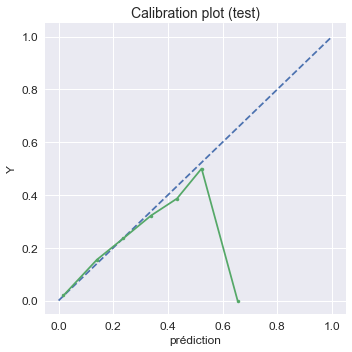

In [159]:
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], linestyle='--')
#plt.plot( calib_curves.loc["LogReg_pred"], calib_curves.loc["LogReg_true"], marker='.')
plt.plot( calib_curves.loc["XGBoost_pred"], calib_curves.loc["XGBoost_true"], marker='.')
plt.title('Calibration plot (test)', fontsize=14)
plt.xlabel('prédiction', fontsize=12)
plt.ylabel('Y')
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.savefig('Results/XGBCalib');
plt.show()

In [160]:
results = pd.DataFrame({'true': y_test, 'predictions': y_pred[:,1]})
results = pd.concat([X_test, results], axis=1)
#results.to_excel("Results/out_XGB.xls", index = True)

# GBM

In [161]:
param_grid_gbm = {
    'max_depth': [6],
    'min_samples_leaf': [20],
    'n_estimators': [100],
    'learning_rate': [0.1],
    'subsample': [1],
    }

param_grid_gbm_bk = {
    'max_depth': [6],
    'min_samples_leaf': [20],
    'n_estimators': [100],
    'learning_rate': [0.1],
    'subsample': [1],
    }

In [162]:
m_GBM = GradientBoostingClassifier()
grid_GBM = GridSearchCV(m_GBM, param_grid_gbm, cv=kfold, scoring={'neg_log_loss','brier_score_loss'}, refit='neg_log_loss', n_jobs = 3)
grid_GBM.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
       error_score='raise-deprecating',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'max_depth': [6], 'min_samples_leaf': [20], 'n_estimators': [100], 'learning_rate': [0.1], 'subsample': [1]},
       pre_dispatch='2*n_jobs', refit='neg_log_loss',
       return_train_score='warn',
       scoring={'neg_log_loss', 'brier_score_loss'}, verbose=0)

In [163]:
grid_GBM.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=6,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=20, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1, tol=0.0001, validation_fraction=0.1, verbose=0,
              warm_start=False)

In [164]:
means = -grid_GBM.cv_results_['mean_test_neg_log_loss']
stds = grid_GBM.cv_results_['std_test_neg_log_loss']
for mean, std, params in zip(means, stds, grid_GBM.cv_results_['params']):
   print("%0.4f (+/-%0.04f) for %r"
   % (mean, std * 2, params))

0.1162 (+/-0.0007) for {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_leaf': 20, 'n_estimators': 100, 'subsample': 1}


In [165]:
y_pred_test = grid_GBM.predict_proba(X_test)
print("Train logloss: ", -grid_GBM.cv_results_['mean_test_neg_log_loss'])
print("Train Brier Score: ", -grid_GBM.cv_results_['mean_test_brier_score_loss'])

print("Test AUC: ", roc_auc_score(y_test, y_pred_test[:,1]))
print("Test logloss: ", log_loss(y_test, y_pred_test[:,1]))
print("Test Brier Score: ", brier_score_loss(y_test, y_pred_test[:,1], pos_label=1))

Train logloss:  [0.1162475]
Train Brier Score:  [0.03023092]
Test AUC:  0.8688653028473576
Test logloss:  0.12191249637981497
Test Brier Score:  0.03205002911651926


In [166]:
fop, mpv = calibration_curve(y_test, y_pred_test[:,1], n_bins=10)
bin_total(y_test, y_pred_test[:,1], n_bins=10)

array([40368,  3110,  1006,   330,    93,    30,     8,     2,     0,
           0,     0], dtype=int64)

In [167]:
calib_curves = calib_curves.append(pd.Series(fop, name="GBM_true"))
calib_curves = calib_curves.append(pd.Series(mpv, name="GBM_pred"))
calib_curves

,0,1,2,3,4,5,6,7
LogReg_true,0.021077,0.154445,0.225501,0.283088,0.301887,0.300000,NaN,NaN
LogReg_pred,0.018395,0.139213,0.243059,0.339597,0.440382,0.540710,NaN,NaN
XGBoost_true,0.019364,0.155099,0.235237,0.322176,0.386364,0.500000,0.000000,NaN
XGBoost_pred,0.017779,0.140378,0.236455,0.338438,0.433045,0.523111,0.654786,NaN
GBM_true,0.020090,0.151125,0.232604,0.272727,0.397849,0.533333,0.125000,0.000000
GBM_pred,0.017047,0.140289,0.239690,0.341964,0.440530,0.545914,0.643621,0.717087


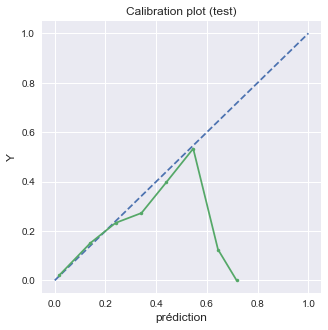

In [168]:
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot( calib_curves.loc["GBM_pred"], calib_curves.loc["GBM_true"], marker='.')
plt.title('Calibration plot (test)')
plt.xlabel('prédiction')
plt.ylabel('Y')
plt.savefig('Results/GBMCalib');
plt.show()

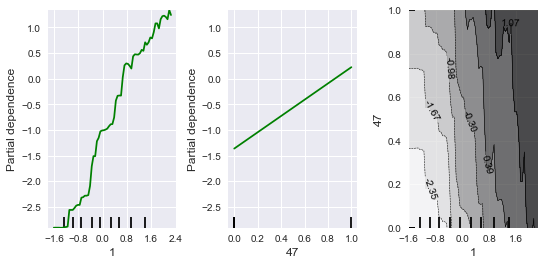

In [169]:
fig, ax = plot_partial_dependence(grid_GBM.best_estimator_, features=[1, 47, (1,47)], X=X_train)
fig.savefig('Results/GBM_pdp');

In [170]:
partial_dependence(grid_GBM.best_estimator_, X=X_train, target_variables=[47])

(array([[-1.36367317,  0.22414336]]), [array([0., 1.], dtype=float32)])

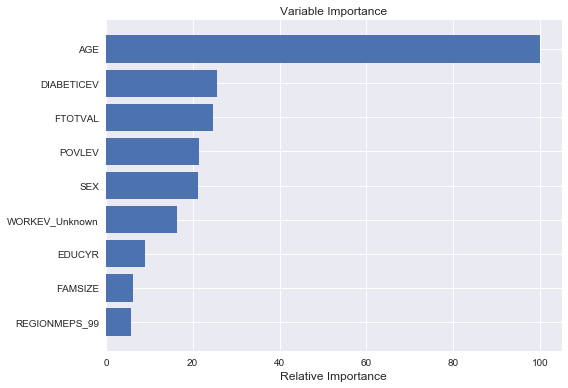

In [171]:
feature_importance = grid_GBM.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(1, 2, 2)
feature_importance = feature_importance[sorted_idx]
col = X_train.columns[sorted_idx]
plt.barh(pos[40:50], feature_importance[40:50], align='center')
plt.yticks(pos[40:50], col[40:50] )
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tight_layout()
plt.savefig('Results/GBM_FI')
plt.show()

In [172]:
feature_importance.shape

(49,)

# Random Forest

In [173]:
param_grid_RF = {
    'max_depth': [12],
    'min_samples_leaf': [10],
    'max_features': ['auto'],
    'n_estimators': [300]
    }

In [174]:
RandForest = RandomForestClassifier(n_jobs=-1)
grid_RF = GridSearchCV(RandForest, param_grid_RF, cv=kfold, scoring={'neg_log_loss','brier_score_loss'}, refit='neg_log_loss')
grid_RF.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [12], 'min_samples_leaf': [10], 'max_features': ['auto'], 'n_estimators': [300]},
       pre_dispatch='2*n_jobs', refit='neg_log_loss',
       return_train_score='warn',
       scoring={'neg_log_loss', 'brier_score_loss'}, verbose=0)

In [175]:
grid_RF.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [176]:
means = -grid_RF.cv_results_['mean_test_neg_log_loss']
stds = grid_RF.cv_results_['std_test_neg_log_loss']
for mean, std, params in zip(means, stds, grid_RF.cv_results_['params']):
   print("%0.4f (+/-%0.04f) for %r"
   % (mean, std * 2, params))

0.1160 (+/-0.0002) for {'max_depth': 12, 'max_features': 'auto', 'min_samples_leaf': 10, 'n_estimators': 300}


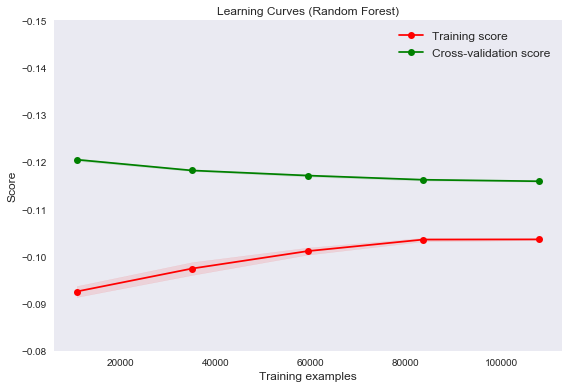

In [184]:
title = "Learning Curves (Random Forest)"
#plt.figure(figsize=(7,5))
plt = plot_learning_curve(grid_RF.best_estimator_, title, X_train, y_train, ylim=(-0.08, -0.15), cv=kfold, n_jobs=3)
plt.tight_layout()
plt.savefig('Results/Learningcurve');

In [185]:
y_pred = grid_RF.predict_proba(X_test)
print("Train logloss: ", -grid_RF.cv_results_['mean_test_neg_log_loss'])
print("Train Brier Score: ", -grid_RF.cv_results_['mean_test_brier_score_loss'])

print("Test AUC: ", roc_auc_score(y_test, y_pred[:,1]))
print("Test logloss: ", log_loss(y_test, y_pred[:,1]))
print("Test Brier Score: ", brier_score_loss(y_test, y_pred[:,1], pos_label=1))

Train logloss:  [0.11597013]
Train Brier Score:  [0.03009111]
Test AUC:  0.8708006422966454
Test logloss:  0.12164285853554353
Test Brier Score:  0.03195395977272055


In [186]:
fop, mpv = calibration_curve(y_test, y_pred[:,1], n_bins=10)
bin_total(y_test, y_pred[:,1], n_bins=10)

array([40062,  4131,   719,    35,     0,     0,     0,     0,     0,
           0,     0], dtype=int64)

In [187]:
calib_curves = calib_curves.append(pd.Series(fop, name="RF_true"))
calib_curves = calib_curves.append(pd.Series(mpv, name="RF_pred"))
calib_curves

,0,1,2,3,4,5,6,7
LogReg_true,0.021077,0.154445,0.225501,0.283088,0.301887,0.300000,NaN,NaN
LogReg_pred,0.018395,0.139213,0.243059,0.339597,0.440382,0.540710,NaN,NaN
XGBoost_true,0.019364,0.155099,0.235237,0.322176,0.386364,0.500000,0.000000,NaN
XGBoost_pred,0.017779,0.140378,0.236455,0.338438,0.433045,0.523111,0.654786,NaN
GBM_true,0.020090,0.151125,0.232604,0.272727,0.397849,0.533333,0.125000,0.000000
GBM_pred,0.017047,0.140289,0.239690,0.341964,0.440530,0.545914,0.643621,0.717087
RF_true,0.018746,0.163641,0.297636,0.514286,NaN,NaN,NaN,NaN
RF_pred,0.020059,0.139039,0.234539,0.319124,NaN,NaN,NaN,NaN


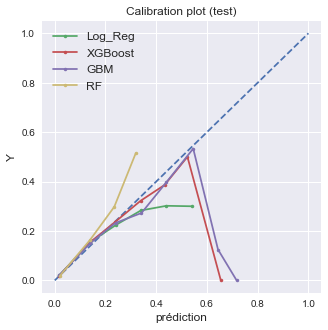

In [188]:
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot( calib_curves.loc["LogReg_pred"], calib_curves.loc["LogReg_true"], marker='.', label="Log_Reg")
plt.plot( calib_curves.loc["XGBoost_pred"], calib_curves.loc["XGBoost_true"], marker='.', label="XGBoost")
plt.plot( calib_curves.loc["GBM_pred"], calib_curves.loc["GBM_true"], marker='.', label="GBM")
plt.plot( calib_curves.loc["RF_pred"], calib_curves.loc["RF_true"], marker='.', label="RF")
plt.legend()
plt.title('Calibration plot (test)')
plt.xlabel('prédiction')
plt.ylabel('Y')
plt.savefig('Results/all_pdp');
plt.show()

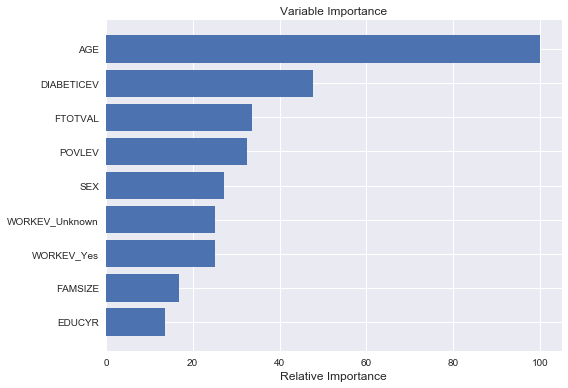

In [189]:
feature_importance = grid_RF.best_estimator_.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
#plt.subplot(1, 2, 2)
feature_importance = feature_importance[sorted_idx]
col = X_train.columns[sorted_idx]
plt.barh(pos[40:50], feature_importance[40:50], align='center')
plt.yticks(pos[40:50], col[40:50] )
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tight_layout()
plt.savefig('Results/RF_FI')
plt.show()

# naive model

In [207]:
y_pred_naiv = np.full((len(y_test),1), y_train.mean())

In [208]:
print("Test logloss: ", log_loss(y_test, y_pred_naiv))
print("Test Brier Score: ", brier_score_loss(y_test, y_pred_naiv, pos_label=1))

Test logloss:  0.15807277877820555
Test Brier Score:  0.035552960383514826
